In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot
vapeplot.set_palette('vaporwave')

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


data = 'square'
policies = [
    'ens jensen greedy',
    'greedy',
    'round robin greedy'
]
utility_function = log_utility

n_exps = 20
n_classes = 6
budget = 100

basepath = os.path.join('../../data/results', data)


utilities = np.ones((len(policies), n_exps, budget)) * -1

for p_ind, policy in enumerate(policies):
    for i in range(n_exps):
        labels = np.loadtxt(
            os.path.join(basepath, policy, f'{policy}__queried_labels__{i + 1}.csv'), 
            dtype=int
        ).flatten() - 1

        utilities[p_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities[..., -1].mean(axis=1)

array([14.19793395, 13.09320786, 12.38948149])

ens jensen greedy: 14.1979
greedy: 13.0932
round robin greedy: 12.3895


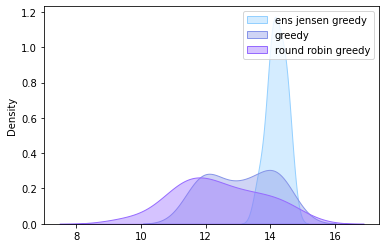

In [4]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, :, -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, :, -1], alpha=0.4, shade=True, label=policy)
    
plt.legend();

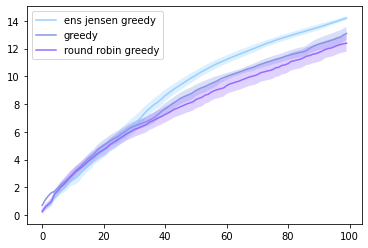

In [5]:
for p_ind, policy in enumerate(policies):
    plt.plot(utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(budget), lower, upper, alpha=0.3)
    
plt.legend();